<a href="https://colab.research.google.com/github/engenheiroadilsoncabaca/Projeto-inteligencia-A/blob/main/deteccao_falhas_melhorado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto: Detecção de Falhas em Chapas de Aço Inoxidável

Este notebook contém melhorias e otimizações no pipeline de classificação multilabel para detectar falhas em chapas de aço inoxidável.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import files
uploaded = files.upload()


Saving bootcamp_train.csv to bootcamp_train.csv


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, f1_score, hamming_loss,
                             classification_report, multilabel_confusion_matrix)
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

from xgboost import XGBClassifier
from sklearn.metrics import make_scorer


import warnings
warnings.filterwarnings("ignore")


# **Carregar o dataset.**

In [5]:

# Carregar dataset
df = pd.read_csv("bootcamp_train.csv")

# Converter colunas binárias
binarias = [
    'falha_1', 'falha_2', 'falha_4', 'falha_5', 'falha_6', 'falha_outros',
    'tipo_do_aço_A300', 'tipo_do_aço_A400'
]

def convert_to_binary(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, str):
        if value.lower() in ['true', '1']:
            return 1
        elif value.lower() in ['false', '0']:
            return 0
    return int(bool(value))

for col in binarias:
    df[col] = df[col].apply(convert_to_binary)

# Converter falha_3 e falha_6 que já são booleanas
df['falha_3'] = df['falha_3'].astype(int)
df['falha_6'] = df['falha_6'].astype(int)

# Imputação de valores ausentes
num_features = df.select_dtypes(include=[np.number]).columns.tolist()
imputer = SimpleImputer(strategy='median')
df[num_features] = imputer.fit_transform(df[num_features])
df['tipo_do_aço_A400'] = df['tipo_do_aço_A400'].fillna(0)

# Criar coluna auxiliar: tem_falha
falhas = ['falha_1', 'falha_2', 'falha_3', 'falha_4', 'falha_5', 'falha_6', 'falha_outros']
df['tem_falha'] = df[falhas].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)


Formato do dataset: (3390, 40)


,id,x_minimo,x_maximo,y_minimo,y_maximo,peso_da_placa,area_pixels,perimetro_x,perimetro_y,soma_da_luminosidade,...,sigmoide_das_areas,minimo_da_luminosidade,falha_1,falha_2,falha_3,falha_4,falha_5,falha_6,falha_outros,tem_falha
0,0.0,154.0,169.0,260124.0,260136.0,100.0,75.0,27.0,17.0,9948.0,...,0.3068,125.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1
1,1.0,1121.0,-186.0,1789332.0,1789337.0,100.0,-206.0,9.0,-194.0,2240.0,...,0.1441,115.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1
2,2.0,41.0,216.0,2708878.0,2708939.0,100.0,6298.0,275.0,134.0,654634.0,...,1.0000,42.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1
3,3.0,129.0,157.0,86408.0,86427.0,100.0,276.0,39.0,26.0,33858.0,...,0.8223,115.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1
4,4.0,436.0,442.0,4959398.0,530985.0,100.0,63.0,17.0,17.0,6374.0,...,0.2083,90.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1


,id,x_minimo,x_maximo,y_minimo,y_maximo,peso_da_placa,area_pixels,perimetro_x,perimetro_y,soma_da_luminosidade,...,sigmoide_das_areas,minimo_da_luminosidade,falha_1,falha_2,falha_3,falha_4,falha_5,falha_6,falha_outros,tem_falha
count,3390.000000,3390.000000,3390.000000,3.390000e+03,3.390000e+03,3390.0,3390.000000,3390.000000,3390.000000,3.390000e+03,...,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.0,3390.000000,3390.0,3390.0
mean,1694.500000,995.507375,604.877581,2.692640e+06,1.592301e+06,100.0,1566.317699,66.733923,47.261062,1.879376e+05,...,0.570363,171.763422,0.099410,0.077876,0.191445,0.053392,1.0,0.237758,1.0,1.0
std,978.753033,1796.737709,543.587428,5.625693e+06,1.821345e+06,0.0,4337.683975,195.092105,336.794632,4.492137e+05,...,0.335394,272.952080,0.299256,0.268016,0.393497,0.224848,0.0,0.425773,0.0,0.0
min,0.000000,-11.000000,-186.000000,-2.000000e+01,-1.660000e+02,100.0,-206.000000,-229.000000,-194.000000,2.550000e+02,...,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,1.0,1.0
25%,847.250000,41.000000,181.250000,3.934352e+05,3.407380e+05,100.0,68.000000,12.000000,11.000000,9.714000e+03,...,0.248200,71.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,1.0,1.0
50%,1694.500000,614.000000,544.000000,1.265462e+06,1.128297e+06,100.0,142.000000,22.000000,21.000000,1.783600e+04,...,0.472100,93.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,1.0,1.0
75%,2541.750000,1187.500000,1088.000000,2.555025e+06,2.184335e+06,100.0,524.750000,58.000000,56.000000,6.292600e+04,...,0.999300,111.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,1.0,1.0
max,3389.000000,15266.000000,1713.000000,1.041366e+08,1.291709e+07,100.0,152655.000000,1275.000000,18152.000000,1.159141e+07,...,1.000000,2086.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            3390 non-null   float64
 1   x_minimo                      3390 non-null   float64
 2   x_maximo                      3390 non-null   float64
 3   y_minimo                      3390 non-null   float64
 4   y_maximo                      3390 non-null   float64
 5   peso_da_placa                 3390 non-null   float64
 6   area_pixels                   3390 non-null   float64
 7   perimetro_x                   3390 non-null   float64
 8   perimetro_y                   3390 non-null   float64
 9   soma_da_luminosidade          3390 non-null   float64
 10  maximo_da_luminosidade        3390 non-null   float64
 11  comprimento_do_transportador  3390 non-null   float64
 12  tipo_do_aço_A300              3390 non-null   float64
 13  tip

None

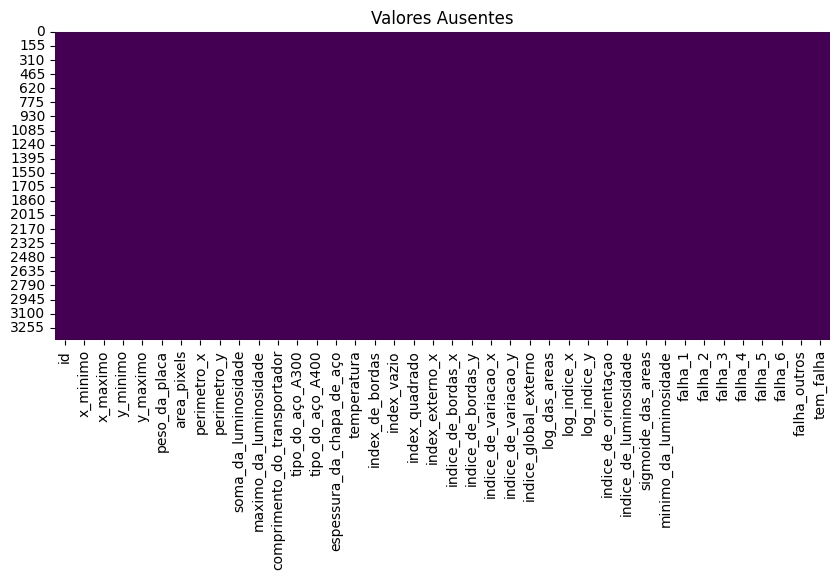

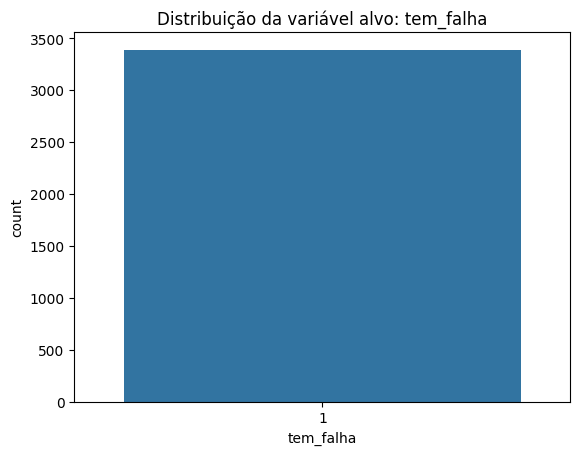

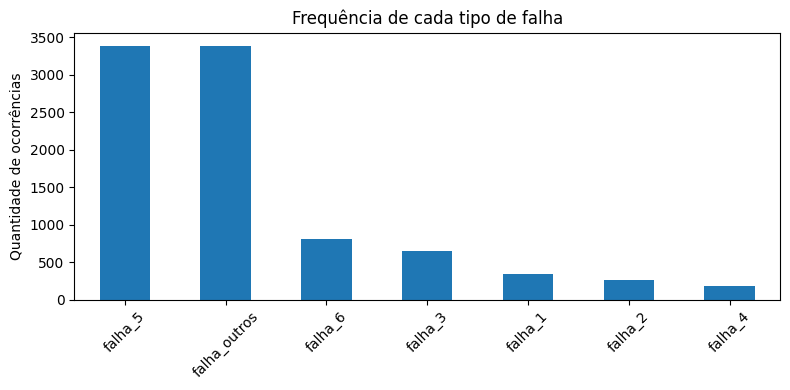

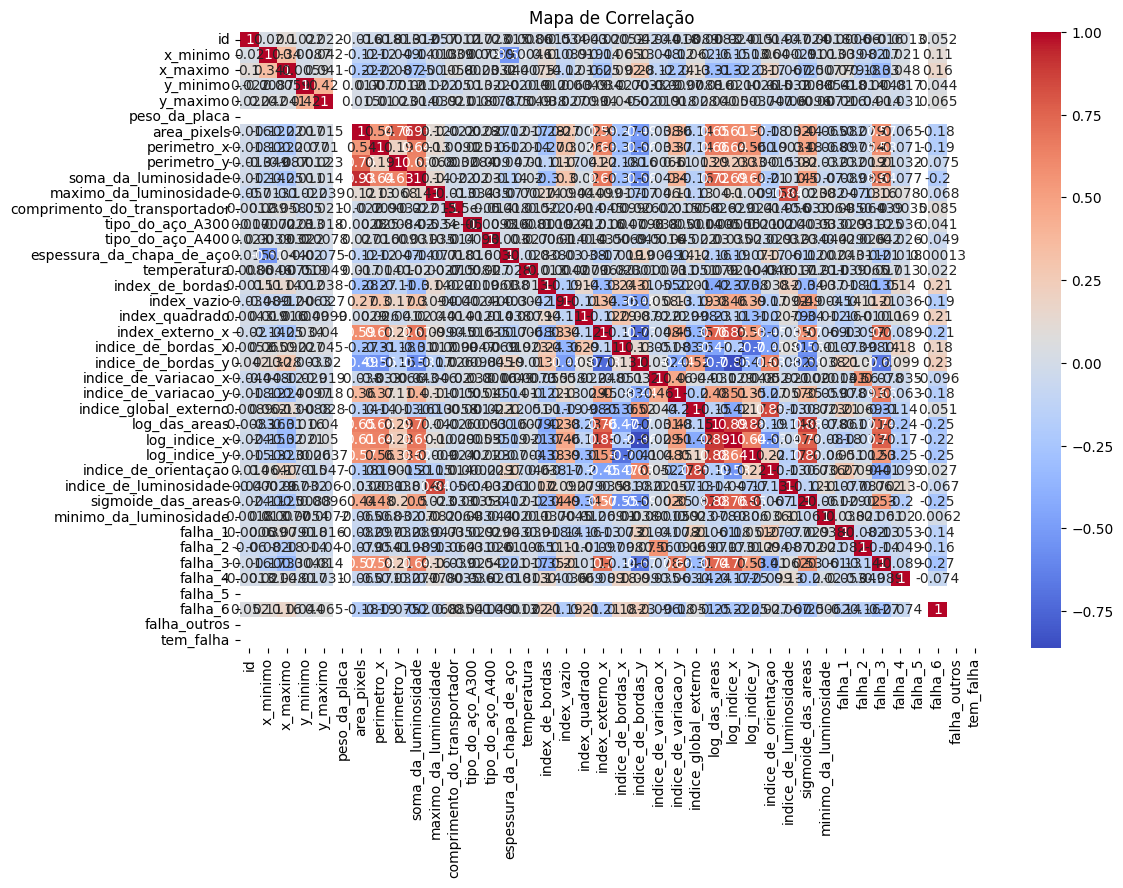

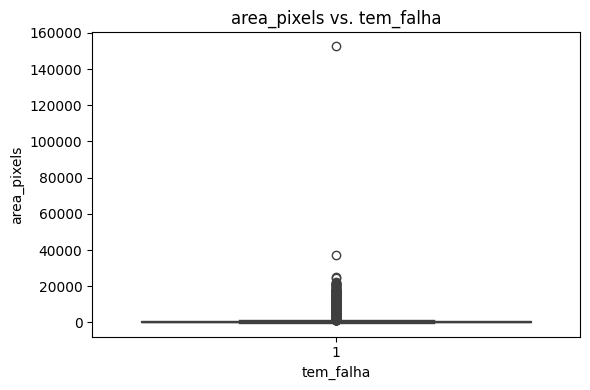

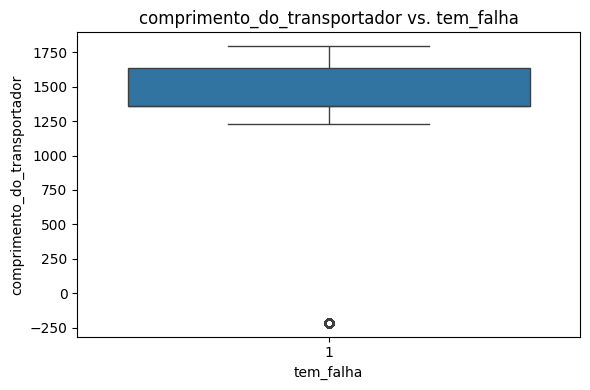

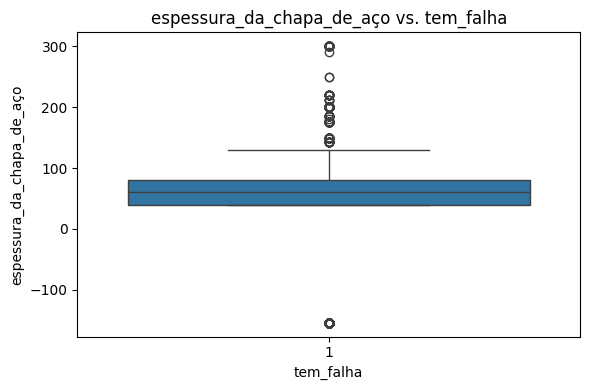

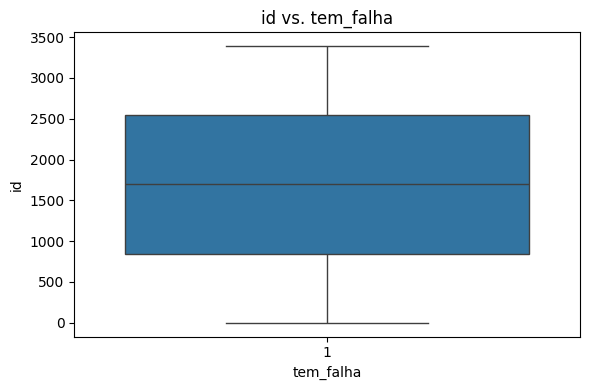

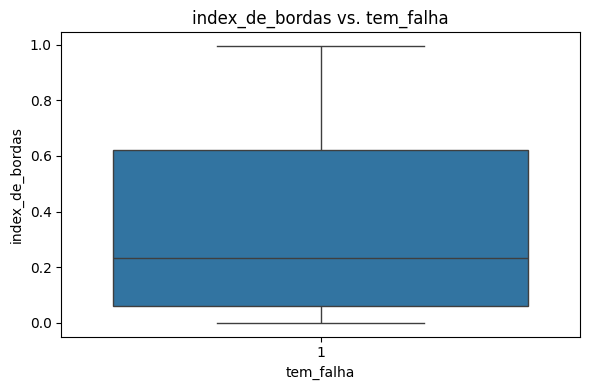

In [8]:
# ==========================================
#  Análise Exploratória de Dados (EDA)
# ==========================================

# Visão geral do dataset
print("Formato do dataset:", df.shape)
display(df.head())
display(df.describe())
display(df.info())

# Verificar valores ausentes
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Valores Ausentes")
plt.show()

# Distribuição da variável alvo (tem_falha)
sns.countplot(data=df, x='tem_falha')
plt.title("Distribuição da variável alvo: tem_falha")
plt.show()

# Distribuição das falhas
df[falhas].sum().sort_values(ascending=False).plot(kind='bar', figsize=(8, 4))
plt.title("Frequência de cada tipo de falha")
plt.ylabel("Quantidade de ocorrências")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlação entre variáveis numéricas
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Mapa de Correlação")
plt.show()

# Boxplots das features principais por presença de falha
features_numericas = df.select_dtypes(include=[np.number]).columns.difference(falhas + ['tem_falha'])

for col in features_numericas[:5]:  # Para não gerar muitos gráficos, limita a 5
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x='tem_falha', y=col)
    plt.title(f'{col} vs. tem_falha')
    plt.tight_layout()
    plt.show()


# Detecção de Outliers (Boxplots + Z-score)

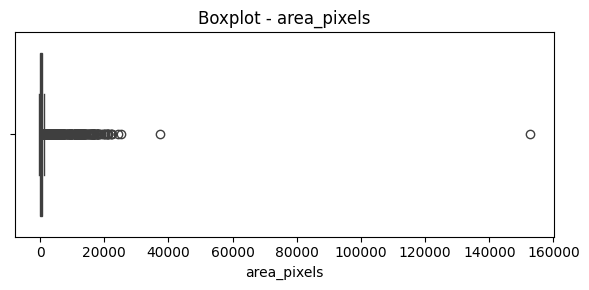

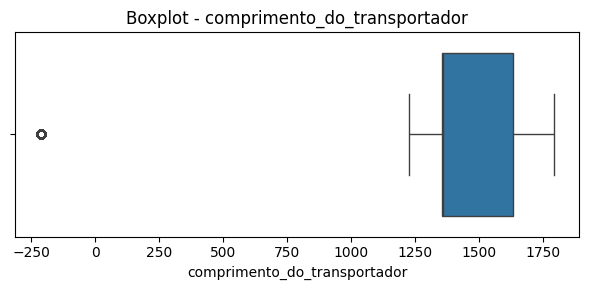

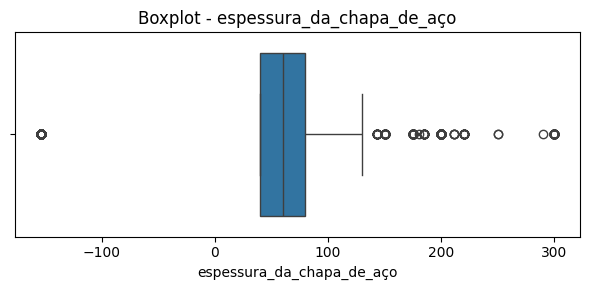

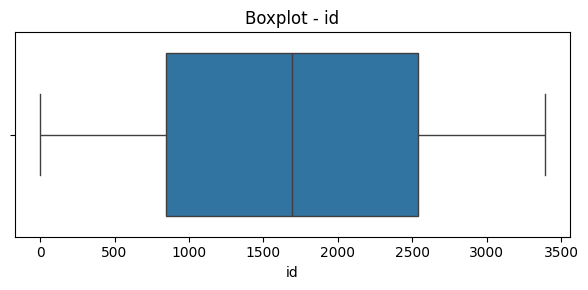

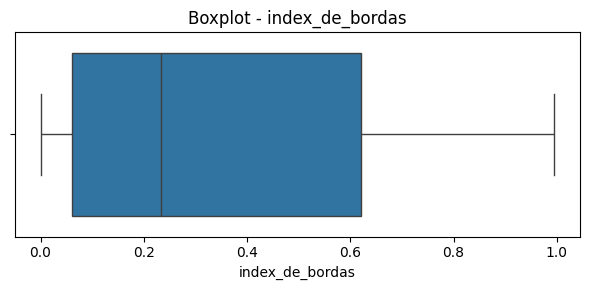

 Quantidade de outliers detectados (z-score > 3):


,0
minimo_da_luminosidade,144
x_minimo,117
perimetro_x,99
indice_de_luminosidade,87
y_maximo,85
maximo_da_luminosidade,79
soma_da_luminosidade,69
y_minimo,66
area_pixels,52
indice_de_variacao_x,51


In [9]:
# ==========================================
#  Detecção de Outliers com Boxplots e Z-Score
# ==========================================
from scipy.stats import zscore

# Selecionar colunas numéricas (excluindo as de falhas)
num_cols = df.select_dtypes(include=[np.number]).columns.difference(falhas + ['tem_falha'])

# Boxplots para visualização rápida
for col in num_cols[:5]:  # limitar a 5 para não poluir visualmente com muitos graficos
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot - {col}")
    plt.tight_layout()
    plt.show()

# Detecção usando z-score
z_scores = df[num_cols].apply(zscore)
outliers = (np.abs(z_scores) > 3).sum().sort_values(ascending=False)

print(" Quantidade de outliers detectados (z-score > 3):")
display(outliers[outliers > 0])


# **Análise de Desequilíbrio entre Classes de Falha**

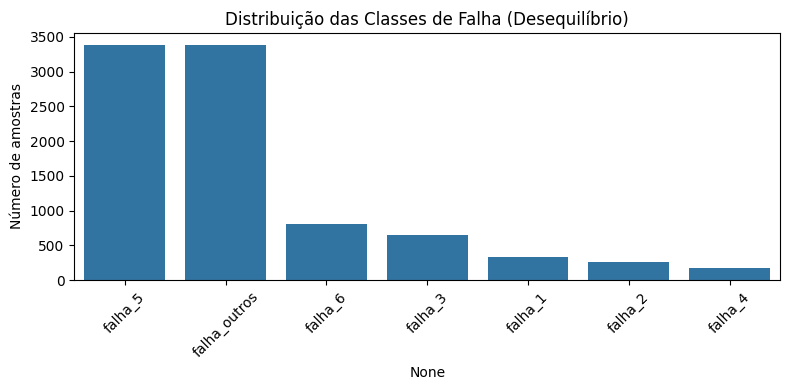

 Frequência absoluta por classe de falha:


,0
falha_5,3390.0
falha_outros,3390.0
falha_6,806.0
falha_3,649.0
falha_1,337.0
falha_2,264.0
falha_4,181.0


In [ ]:
# ==========================================
#  Análise de Desequilíbrio entre Classes
# ==========================================
falha_counts = df[falhas].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=falha_counts.index, y=falha_counts.values)
plt.title("Distribuição das Classes de Falha (Desequilíbrio)")
plt.ylabel("Número de amostras")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(" Frequência absoluta por classe de falha:")
display(falha_counts)


In [ ]:
# ==========================================
# Resumo dos Valores Ausentes por Coluna
# ==========================================
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Coluna': df.columns,
    'Total Ausentes': missing,
    '% Ausente': missing_percent
})
missing_df = missing_df[missing_df['Total Ausentes'] > 0].sort_values(by='% Ausente', ascending=False)

print("Colunas com valores ausentes:")
display(missing_df)


Colunas com valores ausentes:


,Coluna,Total Ausentes,% Ausente


Por conta da imputação de valores, ele subistituiu esses valores pela mediana...

In [10]:

# Separar features e rótulos
X = df.drop(columns=['id', 'tem_falha'] + falhas)
y = df[falhas]

# Pipeline de pré-processamento
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), X.columns)
])

# Transformar os dados
X_scaled = preprocessor.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Separar treino e validação
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [11]:

def avaliar_modelo(y_true, y_pred, nome_modelo="Modelo"):
    print(f"\n🔍 Avaliação do {nome_modelo}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
    print("F1 Score (micro):", f1_score(y_true, y_pred, average='micro'))
    print("Hamming Loss:", hamming_loss(y_true, y_pred))

def plot_confusion_matrices(y_true, y_pred, labels, model_name=""):
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    for i, matrix in enumerate(mcm):
        plt.figure(figsize=(4, 3))
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Matriz de Confusão - {labels[i]} ({model_name})')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.tight_layout()
        plt.show()


# **Modelo original.**

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

rf_model = OneVsRestClassifier(RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
))
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)


In [26]:

# RandomForest Otimizado com RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

param_dist_rf = {
    "estimator__n_estimators": [100, 200, 300],
    "estimator__max_depth": [10, 15, 20],
    "estimator__min_samples_split": [2, 5, 10],
    "estimator__min_samples_leaf": [1, 2, 5],
    "estimator__max_features": ['sqrt', 'log2']
}

rf_base = OneVsRestClassifier(RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
))

random_search_rf = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist_rf,
    n_iter=15,
    scoring=make_scorer(f1_score, average='macro'),
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search_rf.fit(X_train, y_train)
best_rf_model = random_search_rf.best_estimator_
rf_tuned_pred = best_rf_model.predict(X_val)


Fitting 3 folds for each of 15 candidates, totalling 45 fits


# **Modelo original.**

In [27]:
from xgboost import XGBClassifier

xgb_model = OneVsRestClassifier(
    XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=1,
        random_state=42
    )
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_val)


In [28]:

from xgboost import XGBClassifier

param_dist_xgb = {
    "estimator__n_estimators": [100, 200, 300],
    "estimator__learning_rate": [0.01, 0.05, 0.1],
    "estimator__max_depth": [4, 6, 8],
    "estimator__subsample": [0.7, 0.8, 1.0],
    "estimator__colsample_bytree": [0.7, 0.8, 1.0],
    "estimator__scale_pos_weight": [1, 2, 3],
}

xgb_base = OneVsRestClassifier(XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
))

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist_xgb,
    n_iter=15,
    scoring=make_scorer(f1_score, average='macro'),
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search_xgb.fit(X_train, y_train)
best_xgb_model = random_search_xgb.best_estimator_
xgb_tuned_pred = best_xgb_model.predict(X_val)



Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [29]:
registrar_resultado("RandomForest Original", y_val, rf_pred)
registrar_resultado("XGBoost Original", y_val, xgb_pred)



 Resultados do RandomForest Original
Accuracy: 0.6460176991150443
F1 Score (macro): 0.6897015548831836
F1 Score (micro): 0.9248989023685731
Hamming Loss: 0.054782975136957436

 Resultados do XGBoost Original
Accuracy: 0.6622418879056047
F1 Score (macro): 0.732730894836158
F1 Score (micro): 0.9272727272727272
Hamming Loss: 0.0539401601348504
